In [14]:
# %matplotlib inline
# %matplotlib notebook
# %reload_ext autoreload
# %autoreload 2
# %config InlineBackend.figure_format = 'retina'

# %matplotlib notebook
# %matplotlib inline

import sys
import numpy as np
import pandas as pd
from scipy.stats import kde
import h5py
# import mat73

from pathlib import Path

# Plotting
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl  # noqa
from mpl_toolkits.mplot3d import Axes3D  # noqa
import matplotlib.animation as animation

# For Gradient Line Plotting:
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import seaborn as sns
mpl.style.use('seaborn')

from PhoScripts.Pho_Position_Plots import plot_coloredLine, plot_animated3DPlot, plot_spikes_raster


## Spikes Data:
# A MATLAB struct spikes stored in a .mat file: sessionName.spikes.cellinfo.mat. It can be generated with loadSpikes.m. The processing module ProcessCellMetrics.m used the script loadSpikes.m, to automatically load spike-data from either KiloSort, Phy, or Neurosuite and saves it to a spikes struct. sessionName.spikes.cellinfo.mat is saved to the basepath. The struct has the following fields:

# ts: a 1xN cell-struct for N units each containing a 1xM vector with M spike events in samples.
# times: a 1xN cell-struct for N units each containing a 1xM vector with M spike events in seconds.
# cluID: a 1xN vector with inherited IDs from the applied clustering algorithm.
# UID: a 1xN vector with values 1:N.
# shankID: a 1xN vector containing the corresponding shank/electrode-group each unit (1-indexed).
# maxWaveformCh: a 1xN vector with the channel for the maximum waveform for the units (0-indexed)
# maxWaveformCh1: a 1xN vector with the channel for the maximum waveform for the units (1-indexed)
# total: a 1xN vector with the total number of spikes for each unit.
# peakVoltage: a 1xN vector with spike waveform amplitude (µV).
# filtWaveform: a 1xN cell-struct with spike waveforms from maxWaveformChannel (µV).
# filtWaveform_std: a 1xN cell-struct with the std of the spike waveforms (µV).
# rawWaveform: a 1xN cell-struct with raw spike waveforms (µV).
# rawWaveform_std: a 1xN cell-struct with std of the raw spike waveforms (µV).
# timeWaveform: a 1xN cell-struct with spike timestamps for the waveforms (ms).
# maxWaveform_all: a 1xN vector with channel indexes for the _all waveforms for the units (1-indexed)
# rawWaveform_all: a 1xN cell-struct with raw spike waveforms from maxWaveform_all (µV).
# filtWaveform_all: a 1xN cell-struct with filtered spike waveforms from maxWaveform_all (µV).
# timeWaveform_all: a 1xN cell-struct with spike timestamps for the _all waveforms (ms).
# numcells: the number of cells.
# sessionName: name of the session (string).
# spindices: a Kx2 matrix where the first column contains the K spike times for all units and the second column contains the unit index for each spike.
# processinginfo: a substruct with information about how the spikes were generated including the name of the function, version, date, and the parameters.

# main_data_path = Path(r'/Volumes/iNeo/Data/Rotation_3_Kamran Diba Lab/ClusterFreeAnalysisProject/Data/Achilles_10252013')
# main_data_path = Path(r'../../data/Achilles_10252013')
main_data_path = Path(r'C:\Users\Pho\repos\PhoPy3DPositionAnalysis2021\data\Achilles_10252013')
main_data_path.joinpath('ExportedData', 'Achilles_10252013_spikes')

main_data_path.joinpath('ExportedData', 'Achilles_10252013_position')


# spikesFilename = 'Achilles_10252013.spikes.cellinfo.mat'
spikesFilename = main_data_path.joinpath('ExportedData', 'Achilles_10252013_spikes.mat')
# spikesVariables = 'data/spikes'
# spikesVariables_times = 'data/spikes/times'
spikesVariables = 'spikemat_out'


# positionFilename = 'Achilles_10252013.position.behavior.mat'
positionFilename = main_data_path.joinpath('ExportedData', 'Achilles_10252013_position.mat')
# positionVariables = 'data/pos_out'
positionVariables = 'pos_out'
# positionVariables = 'data/position'

# Computed
spikesFileFullpath = main_data_path.joinpath(spikesFilename) # build a full filepath from the basepath
positionFileFullpath = main_data_path.joinpath(positionFilename) # build a full filepath from the basepath


In [15]:
# mat73.loadmat(spikesFileFullpath)

In [16]:
# # Non-working: Load from picked ndarray:
# active_path = main_data_path.joinpath('ExportedData', 'Achilles_10252013_position')
# data = np.load(active_path, allow_pickle=True)
# data

In [17]:
# Working Load
def loadExportedMatlabData(positionFileFullpath, positionVariables, spikesFileFullpath, spikesVariables):
    # Returns (data_position, data_timestamps, data_spikes, data_spikes_timestamps)
    active_path = positionFileFullpath
    active_variables = positionVariables
    print(active_path)
    f = h5py.File(active_path,'r')
    # print(f.keys())
    data_position = np.array(f.get(active_variables)).T # For converting to a NumPy array. It's (2, 80762) before the transpose, so (80762, 2) after
    # Extract the timestamps from the first dimension of the loaded data_position array
    # data_timestamps = data_position[2,:]
    # print(data_timestamps.shape)
    # Extract just the (x,y) position, and finally overwrite the original array (effectively discarding the timestamps that were extracted in the previous step)
    # data_position = data_position[0:2,:]
    # print(data_position.shape)

    data_timestamps = np.array(f.get('timestamps_out')).T # (1, 80762)
    # print('data_timestamps: {}'.format(data_timestamps.shape))
    # data_samplingRate = np.array(f.get('samplingRate_out'))
    # print('data_samplingRate: {}'.format(data_samplingRate))

    # Spikes Loading:
    active_path = spikesFileFullpath
    active_variables = spikesVariables
    print(active_path)
    f = h5py.File(active_path,'r')
    # print(f.keys())
    data_spikes = np.array(f.get(active_variables)).T
    data_spikes_timestamps = np.array(f.get('spike_timestamps_out'))
    # print(data_spikes)
    return data_position, data_timestamps, data_spikes, data_spikes_timestamps

data_position, data_timestamps, data_spikes, data_spikes_timestamps = loadExportedMatlabData(positionFileFullpath, positionVariables, spikesFileFullpath, spikesVariables)

num_position_timestamps = len(data_timestamps) # 348611
print('data_position: {} \n \t num_position_timestamps: {}'.format(data_position.shape, num_position_timestamps))

num_spikes_timestamps = data_spikes.shape[0] # 348611
num_neurons = data_spikes.shape[1]
print('data_spikes: {}  \n \t num_spikes_timestamps: {}, \t num_neurons: {}'.format(data_spikes.shape, num_spikes_timestamps, num_neurons))


C:\Users\Pho\repos\PhoPy3DPositionAnalysis2021\data\Achilles_10252013\ExportedData\Achilles_10252013_position.mat
C:\Users\Pho\repos\PhoPy3DPositionAnalysis2021\data\Achilles_10252013\ExportedData\Achilles_10252013_spikes.mat
data_position: (2067500, 3) 
 	 num_position_timestamps: 2067500
data_spikes: (2067500, 275)  
 	 num_spikes_timestamps: 2067500, 	 num_neurons: 275


In [18]:
# # Non-working: Load from ?Pandas?:
# active_path = positionFileFullpath
# print('Reading data from file {}...'.format(str(active_path)))
# active_store = pd.HDFStore(active_path)
# print(active_store.keys())

# in_df = active_store[spikesVariables]
# # in_series = active_store['variables_series_of_dataframes']
# # in_records_df = active_store['records_dataframe']
# active_store.close()
# print('done reading {}.'.format(str(active_path)))

# # in_df

t: (2067500,), x: (2067500,), y: (2067500,), lin_pos: (2067500,)
for lin_pos: extrema_min: 5.341493389871183e-05, extrema_max: 1.5999494841876267
for velocity: extrema_min_velocity: -0.08709562215303014, extrema_max_velocity: 0.0810337274113213
lin_speed_threshold: 0.017128984905513473 ([cm]/[sec])


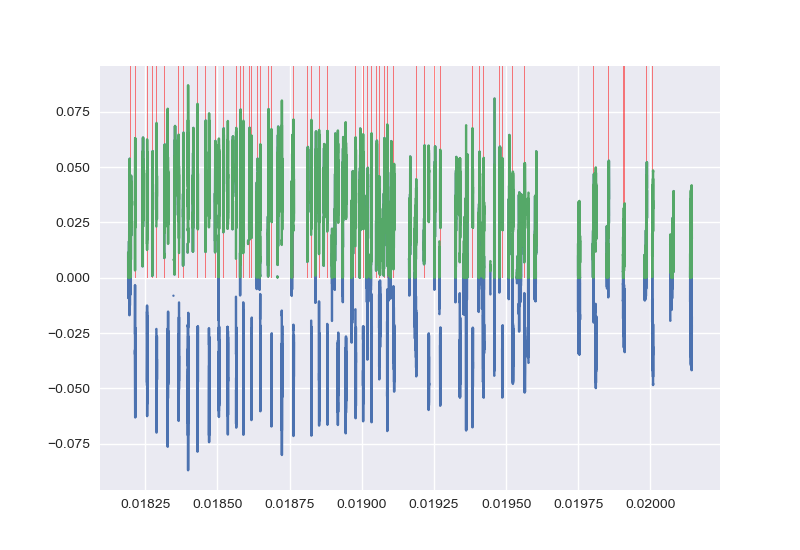

In [19]:
x = data_position[:,0]
y = data_position[:,1]
lin_pos = data_position[:,2]
# x = data_position[0,:]
# y = data_position[1,:]
numPoints = len(y)
timestamp_scale_factor = (1/1E6)
t = data_timestamps[:,0] * timestamp_scale_factor

print('t: {}, x: {}, y: {}, lin_pos: {}'.format(t.shape, x.shape, y.shape, lin_pos.shape))
extrema_min, extrema_max = np.nanmin(lin_pos), np.nanmax(lin_pos)
print('for lin_pos: extrema_min: {}, extrema_max: {}'.format(extrema_min, extrema_max))

# Compute Velocity Vector from linearized positions:
lin_velocity = np.diff(lin_pos, prepend=0) / (t)
extrema_min_velocity, extrema_max_velocity = np.nanmin(lin_velocity), np.nanmax(lin_velocity)
print('for velocity: extrema_min_velocity: {}, extrema_max_velocity: {}'.format(extrema_min_velocity, extrema_max_velocity))
lin_speed = np.abs(lin_velocity)

lin_speed_std = np.nanstd(lin_speed)
lin_speed_threshold = 1 * lin_speed_std
print('lin_speed_threshold: {} ([cm]/[sec])'.format(lin_speed_threshold))
movement_indicies = np.nonzero(lin_speed >= lin_speed_threshold)

fig, ax = plt.subplots()
ax.plot(t, lin_velocity)
ax.plot(t, lin_speed)
collection = mcoll.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=lin_speed >= lin_speed_threshold, facecolor='red', alpha=0.5)
ax.add_collection(collection)

plt.show()

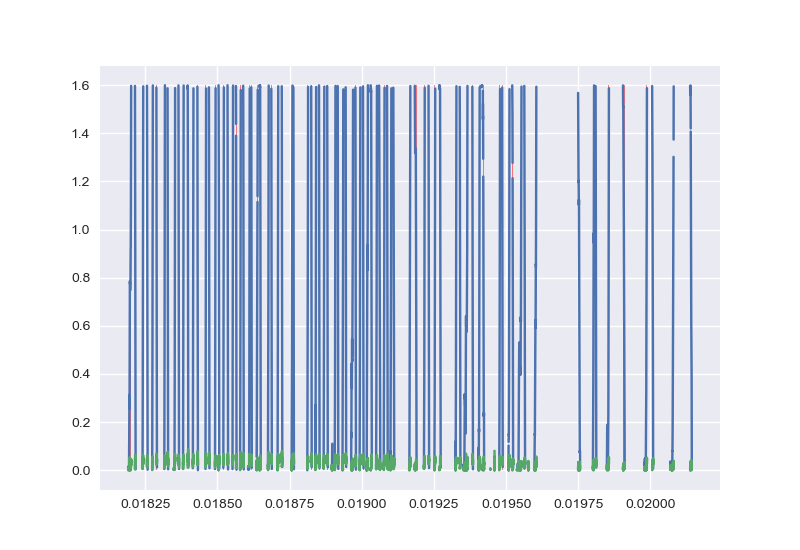

In [20]:
fig, ax = plt.subplots()
# ax.plot(t, lin_velocity)
ax.plot(t, lin_pos)
ax.plot(t, lin_speed)
collection = mcoll.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1.6, where=lin_speed >= lin_speed_threshold, facecolor='red', alpha=0.5)
ax.add_collection(collection)
plt.show()

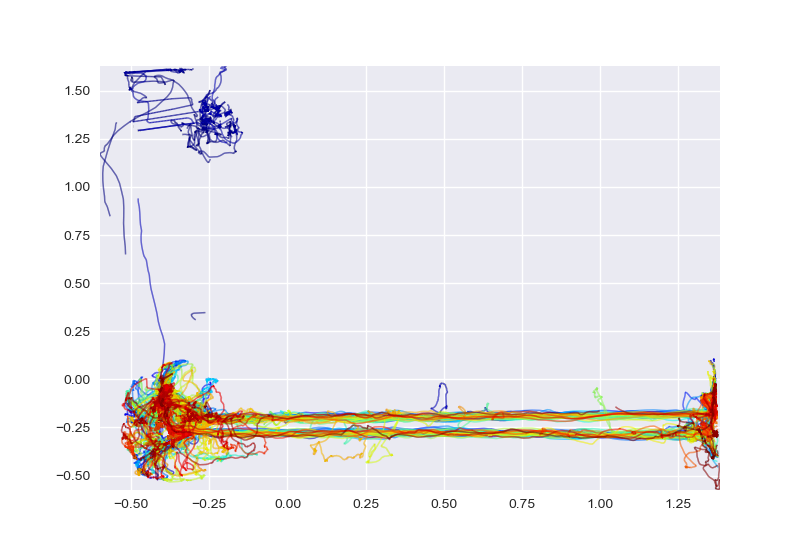

In [21]:
# %% 
# Run Plots:

# plot_animated3DPlot(t, x, y)

plot_coloredLine(x, y)


C:\Users\Pho\repos\PhoPy3DPositionAnalysis2021\PhoPyPlaceCellReplayAnalysis\PhoScripts\Pho_Position_Plots\__init__.py:108: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


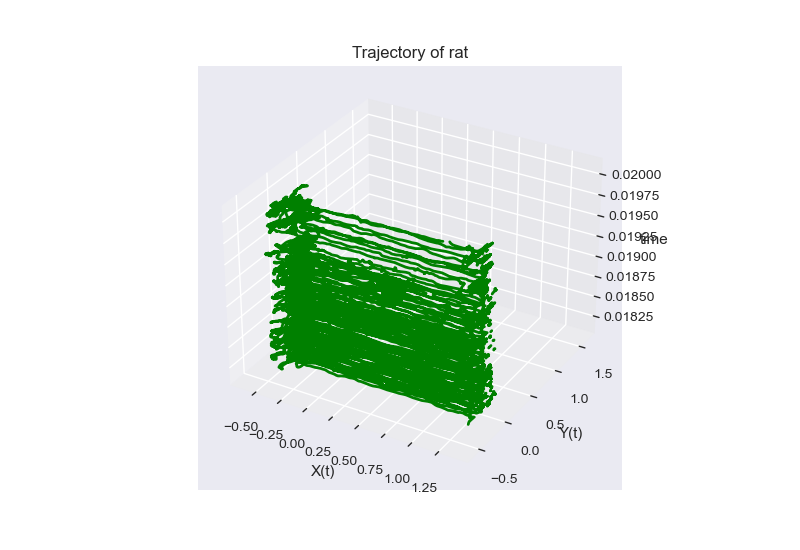

In [22]:
plot_animated3DPlot(t, x, y)

In [10]:
plt.plot(t, lin_pos)

In [11]:
# data_spikes[:100, 0]
# plot_spikes_raster(data_timestamps, data_spikes.T)
spike_ind, neuron_ind = np.nonzero(data_spikes)
print('spike_ind.shape: {}, neuron_ind.shape: {}'.format(spike_ind.shape, neuron_ind.shape))

spike_ind.shape: (1114890,), neuron_ind.shape: (1114890,)


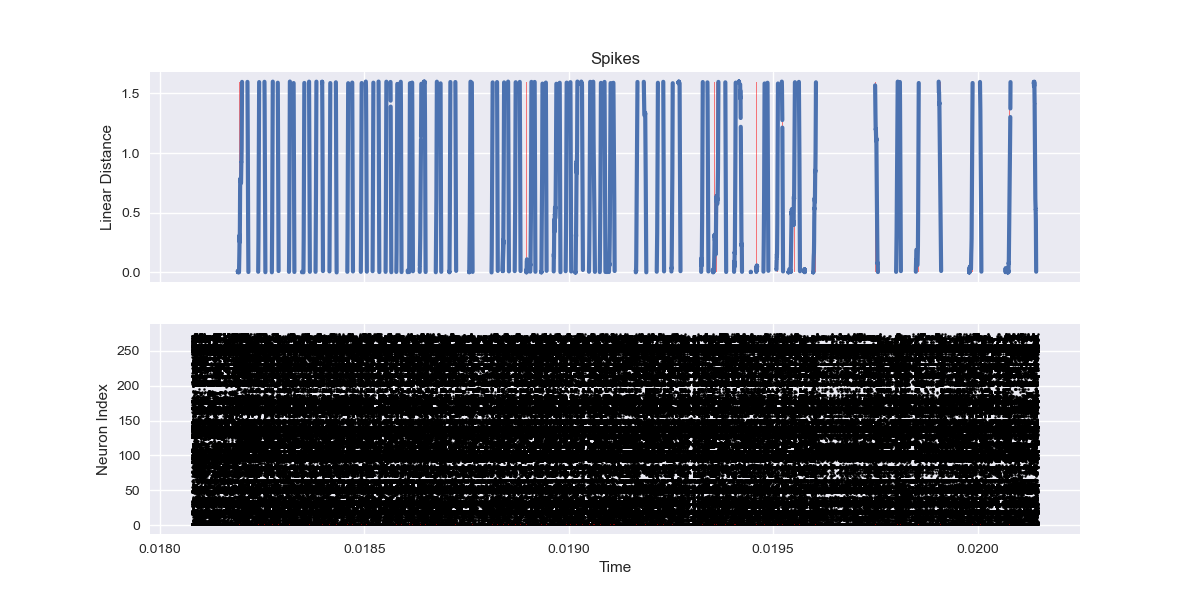

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(t, lin_pos, linewidth=3)
collection = mcoll.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1.6, where=lin_speed >= lin_speed_threshold, facecolor='red', alpha=0.5)
axes[0].add_collection(collection)
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Spikes')
axes[1].scatter(t[spike_ind], neuron_ind + 1, color='black', s=2)
collection = mcoll.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1.6, where=lin_speed >= lin_speed_threshold, facecolor='red', alpha=0.5)
axes[1].add_collection(collection)
axes[1].set_ylabel('Neuron Index')
axes[-1].set_xlabel('Time')
sns.despine()

NameError: name 'data_spikes' is not defined

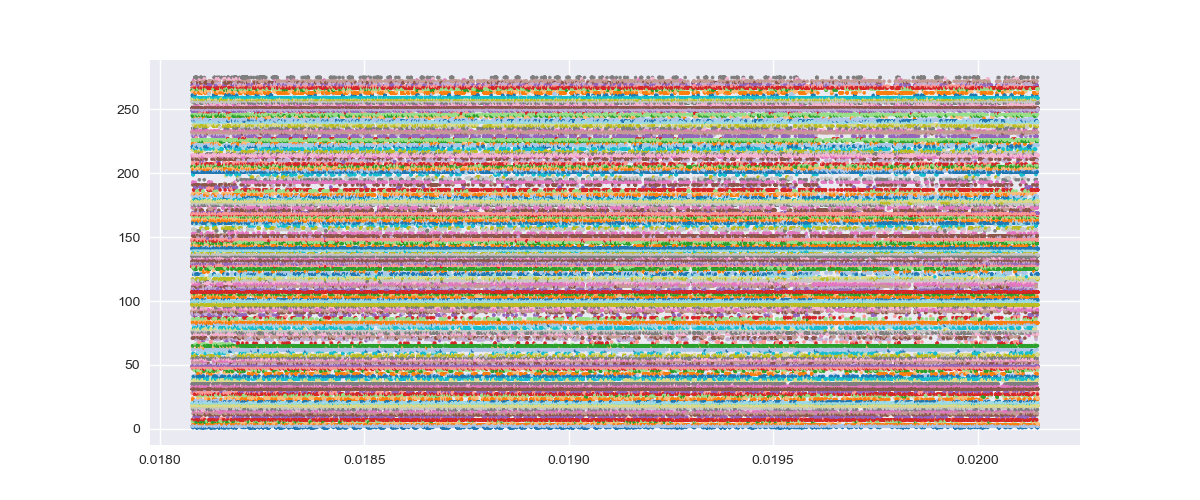

In [13]:
start_time = 18500.0
fig = plot_spikes_raster(t, spike_ind, neuron_ind, start_time)

print(t[1]-t[0])

# spike_ind
# neuron_ind

In [ ]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='16GB')

# from replay_trajectory_classification import (SortedSpikesDecoder, ClusterlessDecoder,
#                                               SortedSpikesClassifier, ClusterlessClassifier)
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

continuous_transition_types = (
    [['random_walk', 'uniform', 'identity'],
     ['uniform', 'uniform', 'uniform'],
     ['random_walk', 'uniform', 'identity']])

In [ ]:


# Estimate the movement variance:
# movement_var = estimate_movement_var(position, sampling_frequency)
# movement_var = estimate_movement_var(data_position[:,0:2], 0.001)
movement_var = estimate_movement_var(lin_pos, 0.001)
print(movement_var)


In [ ]:

# sortedSpikesDecoderOutput = SortedSpikesDecoder.fit(data_position, data_spikes)
# decoder = SortedSpikesDecoder(data_position[:,0:2], data_spikes)

# decoder = SortedSpikesDecoder(movement_var=movement_var,
#                               replay_speed=1,
#                               place_bin_size=np.sqrt(movement_var),
#                               knot_spacing=10)
# # decoder.fit(position, spikes)
# decoder.fit(data_position[:,0:2], data_spikes)

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    place_bin_size=np.sqrt(movement_var),
                                    infer_track_interior=False,
                                    continuous_transition_types=continuous_transition_types,
                                    spike_model_penalty=0.5,
                                    discrete_transition_diag=(1 - 1E-3))
classifier.fit(lin_pos, data_spikes)

